# Imports

In [1]:
library(broom)
library(latex2exp)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(tidyverse)
library(modelr)
library(GGally)
library(corrplot)
library(ggmosaic)
library(glmnet)
library(caret)
library(vcd)
library(pROC)

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 1.1.0 --

v dials        1.2.0     v rsample      1.1.1
v dplyr        1.1.4     v tibble       3.2.1
v ggplot2      3.4.2     v tidyr        1.3.1
v infer        1.0.4     v tune         1.1.1
v modeldata    1.1.0     v workflows    1.1.3
v parsnip      1.1.0     v workflowsets 1.0.1
v purrr        1.0.2     v yardstick    1.3.1
v recipes      1.0.6     

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use tidymodels_prefer() to resolve common conflicts.


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'mltools'


The following objects are masked from 'package:yardstick'

# Data prep

In [25]:
data <- read_csv("data/games.csv", col_names = TRUE, show_col_types = FALSE)

# Change values in the fifth column
data <- data %>%
  mutate(across(5, ~ ifelse(. == 1, 1, 0)))


In [26]:
head(data)

gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3326086514,1.504279e+12,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
3229566029,1.497849e+12,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
3327363504,1.504360e+12,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3326856598,1.504349e+12,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
3330080762,1.504554e+12,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
3287435705,1.501668e+12,2059,9,1,2,2,1,1,2,...,6,0,0,3,0,119,134,154,63,31


## EDA

In [57]:


# df_post_start is all important data during the game, data that will make a team win
df_post_start <- data |>
  select(c(5, 6, 7, 8, 9, 10,11, 27, 28, 29 ,30, 31, 52, 53, 54, 55, 56))

summary(df_post_start)

     winner         firstBlood      firstTower    firstInhibitor 
 Min.   :0.0000   Min.   :0.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:0.0000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :1.0000   Median :1.000   Median :1.000   Median :1.000  
 Mean   :0.5064   Mean   :1.471   Mean   :1.451   Mean   :1.308  
 3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :1.0000   Max.   :2.000   Max.   :2.000   Max.   :2.000  
   firstBaron      firstDragon    firstRiftHerald  t1_towerKills   
 Min.   :0.0000   Min.   :0.000   Min.   :0.0000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:1.000   1st Qu.:0.0000   1st Qu.: 2.000  
 Median :1.0000   Median :1.000   Median :0.0000   Median : 6.000  
 Mean   :0.9265   Mean   :1.443   Mean   :0.7317   Mean   : 5.699  
 3rd Qu.:2.0000   3rd Qu.:2.000   3rd Qu.:1.0000   3rd Qu.: 9.000  
 Max.   :2.0000   Max.   :2.000   Max.   :2.0000   Max.   :11.000  
 t1_inhibitorKills t1_baronKills    t1_dragonKills  t1_riftHer

1 indicate that team 1 wins and 0 indicate that team 2 wins

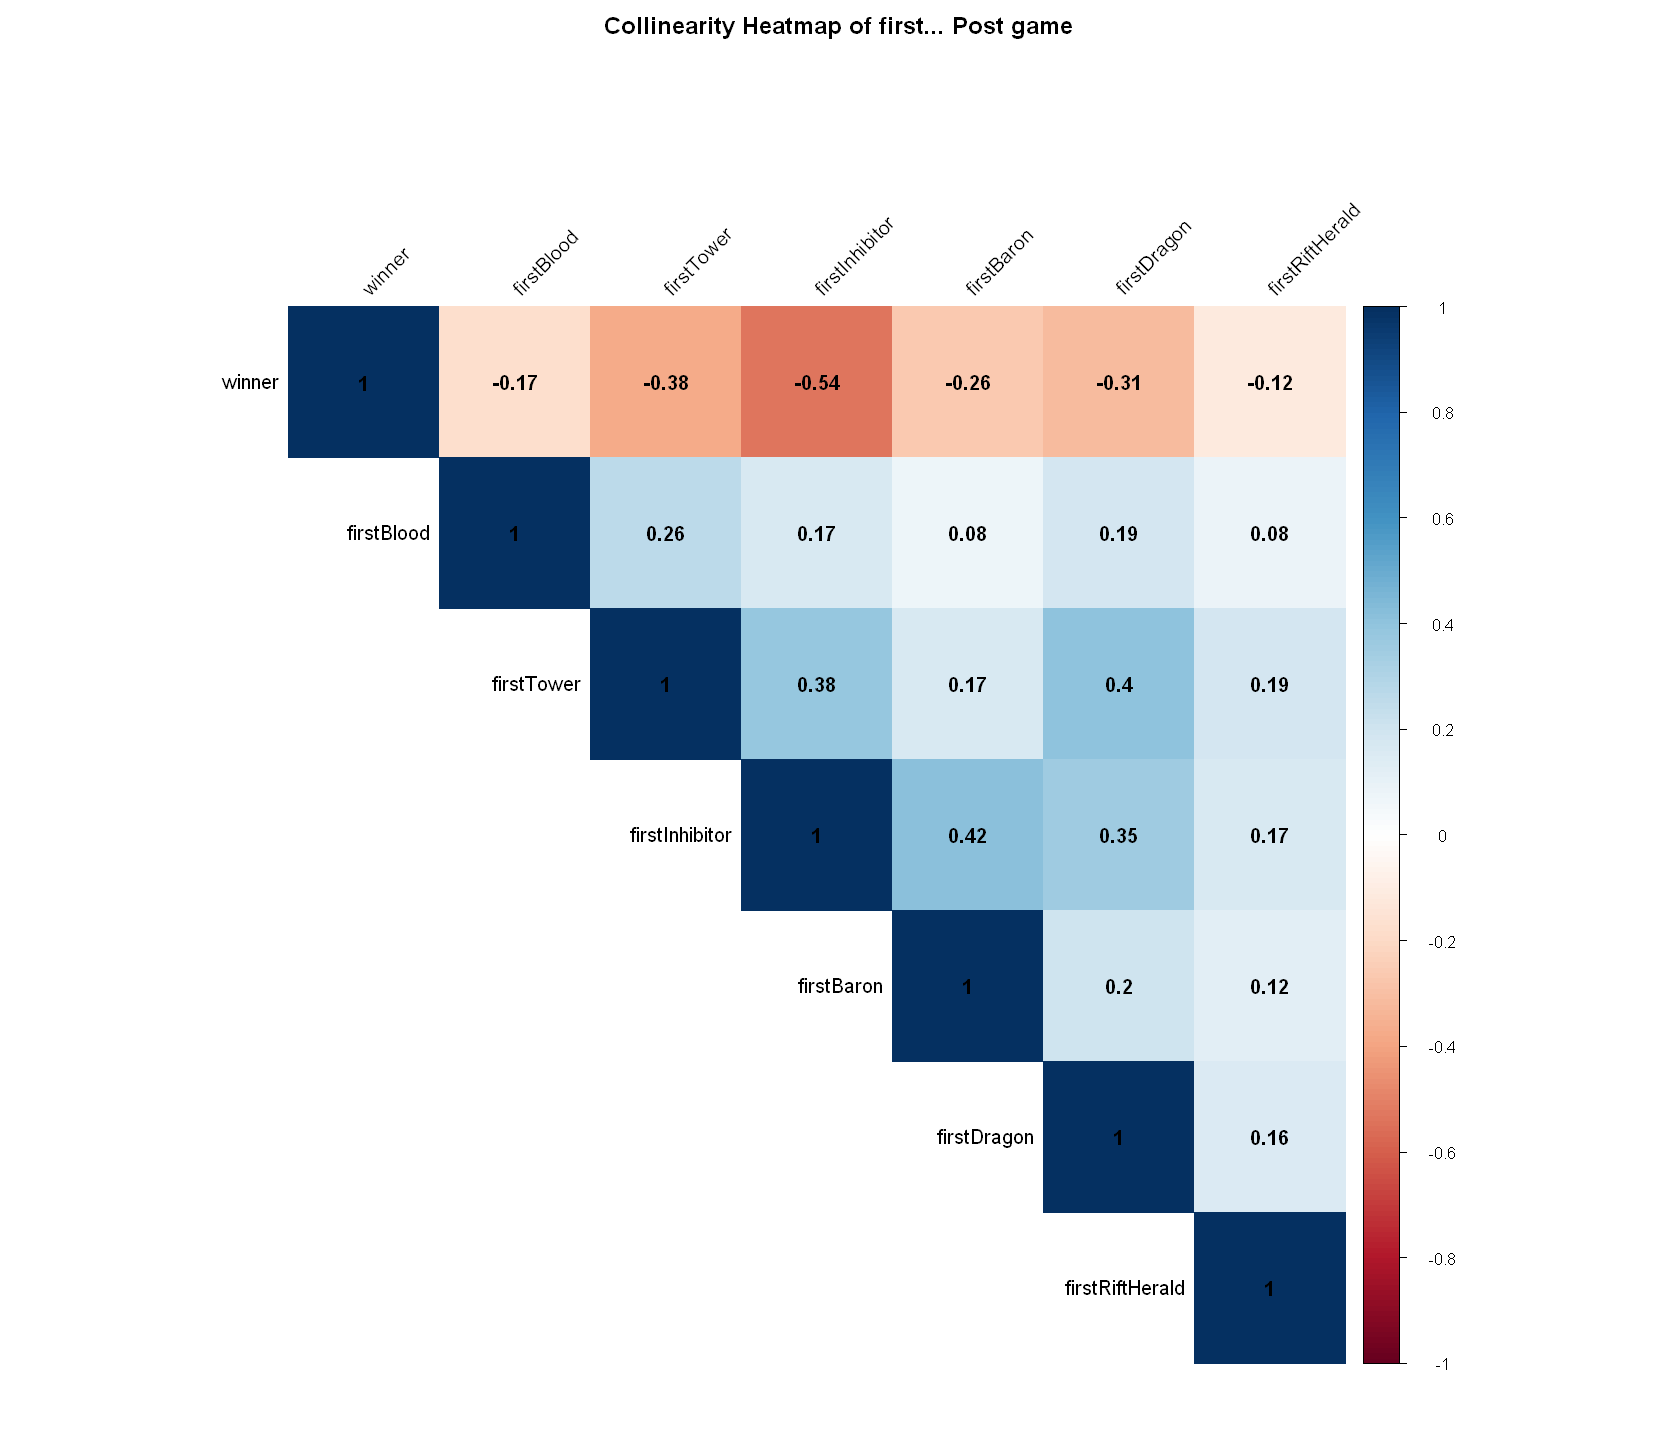

In [58]:
options(repr.plot.width = 14, repr.plot.height = 12) 

correlation_matrix <- data |>
  select(c( 5, 6, 7, 8, 9, 10, 11)) |>
  cor()

par(mar = c(1, 1, 4, 1))  
corrplot(correlation_matrix, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, addCoef.col = "black",
         title = "Collinearity Heatmap of first... Post game", 
         mar = c(0, 0, 2, 0))

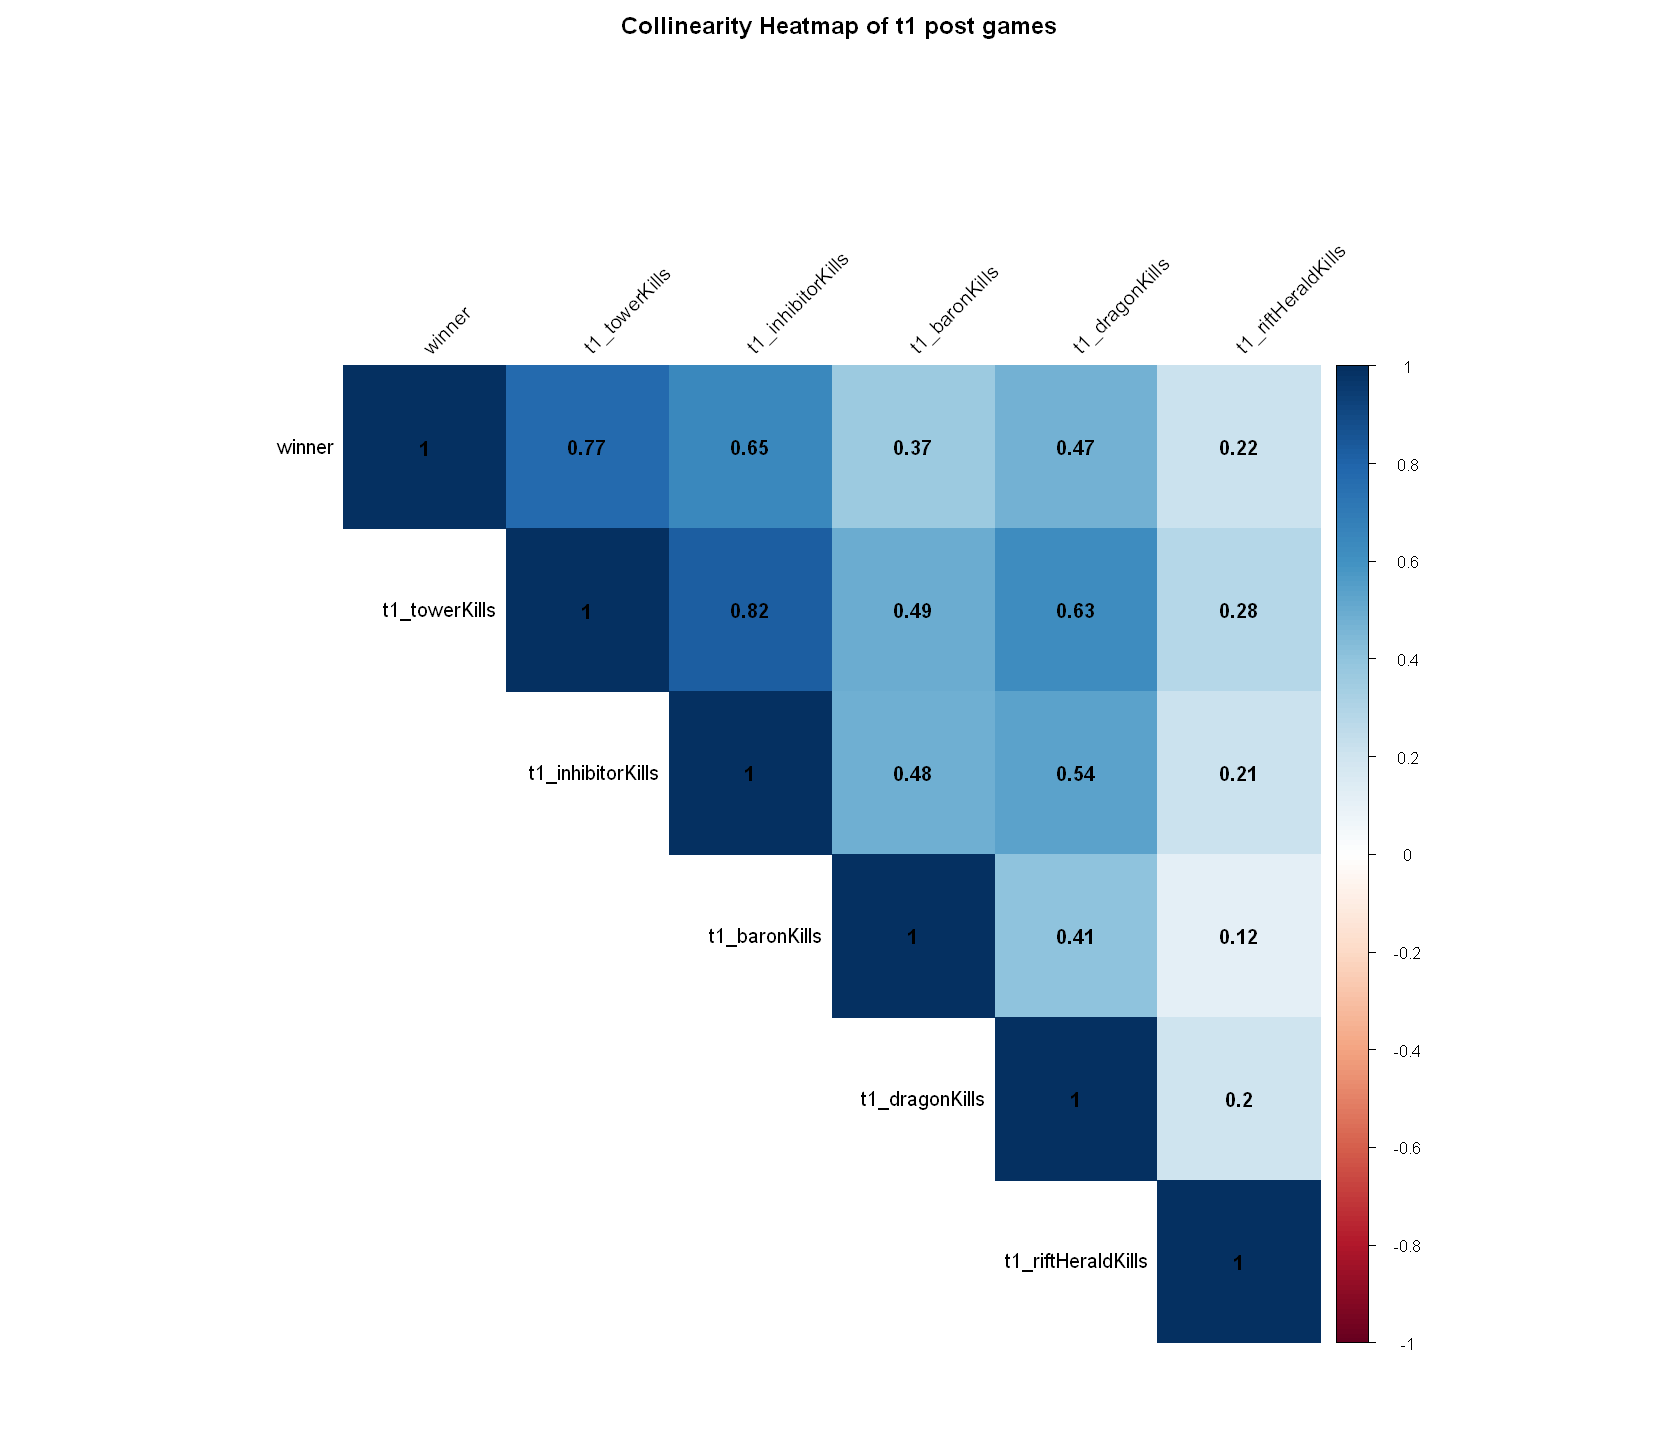

In [59]:
options(repr.plot.width = 14, repr.plot.height = 12) 

correlation_matrix_other <- data |>
  select(c( 5, 27, 28, 29 ,30, 31)) |>
  cor()

par(mar = c(1, 1, 4, 1))  
corrplot(correlation_matrix_other, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, addCoef.col = "black",
         title = "Collinearity Heatmap of t1 post games", 
         mar = c(0, 0, 2, 0))

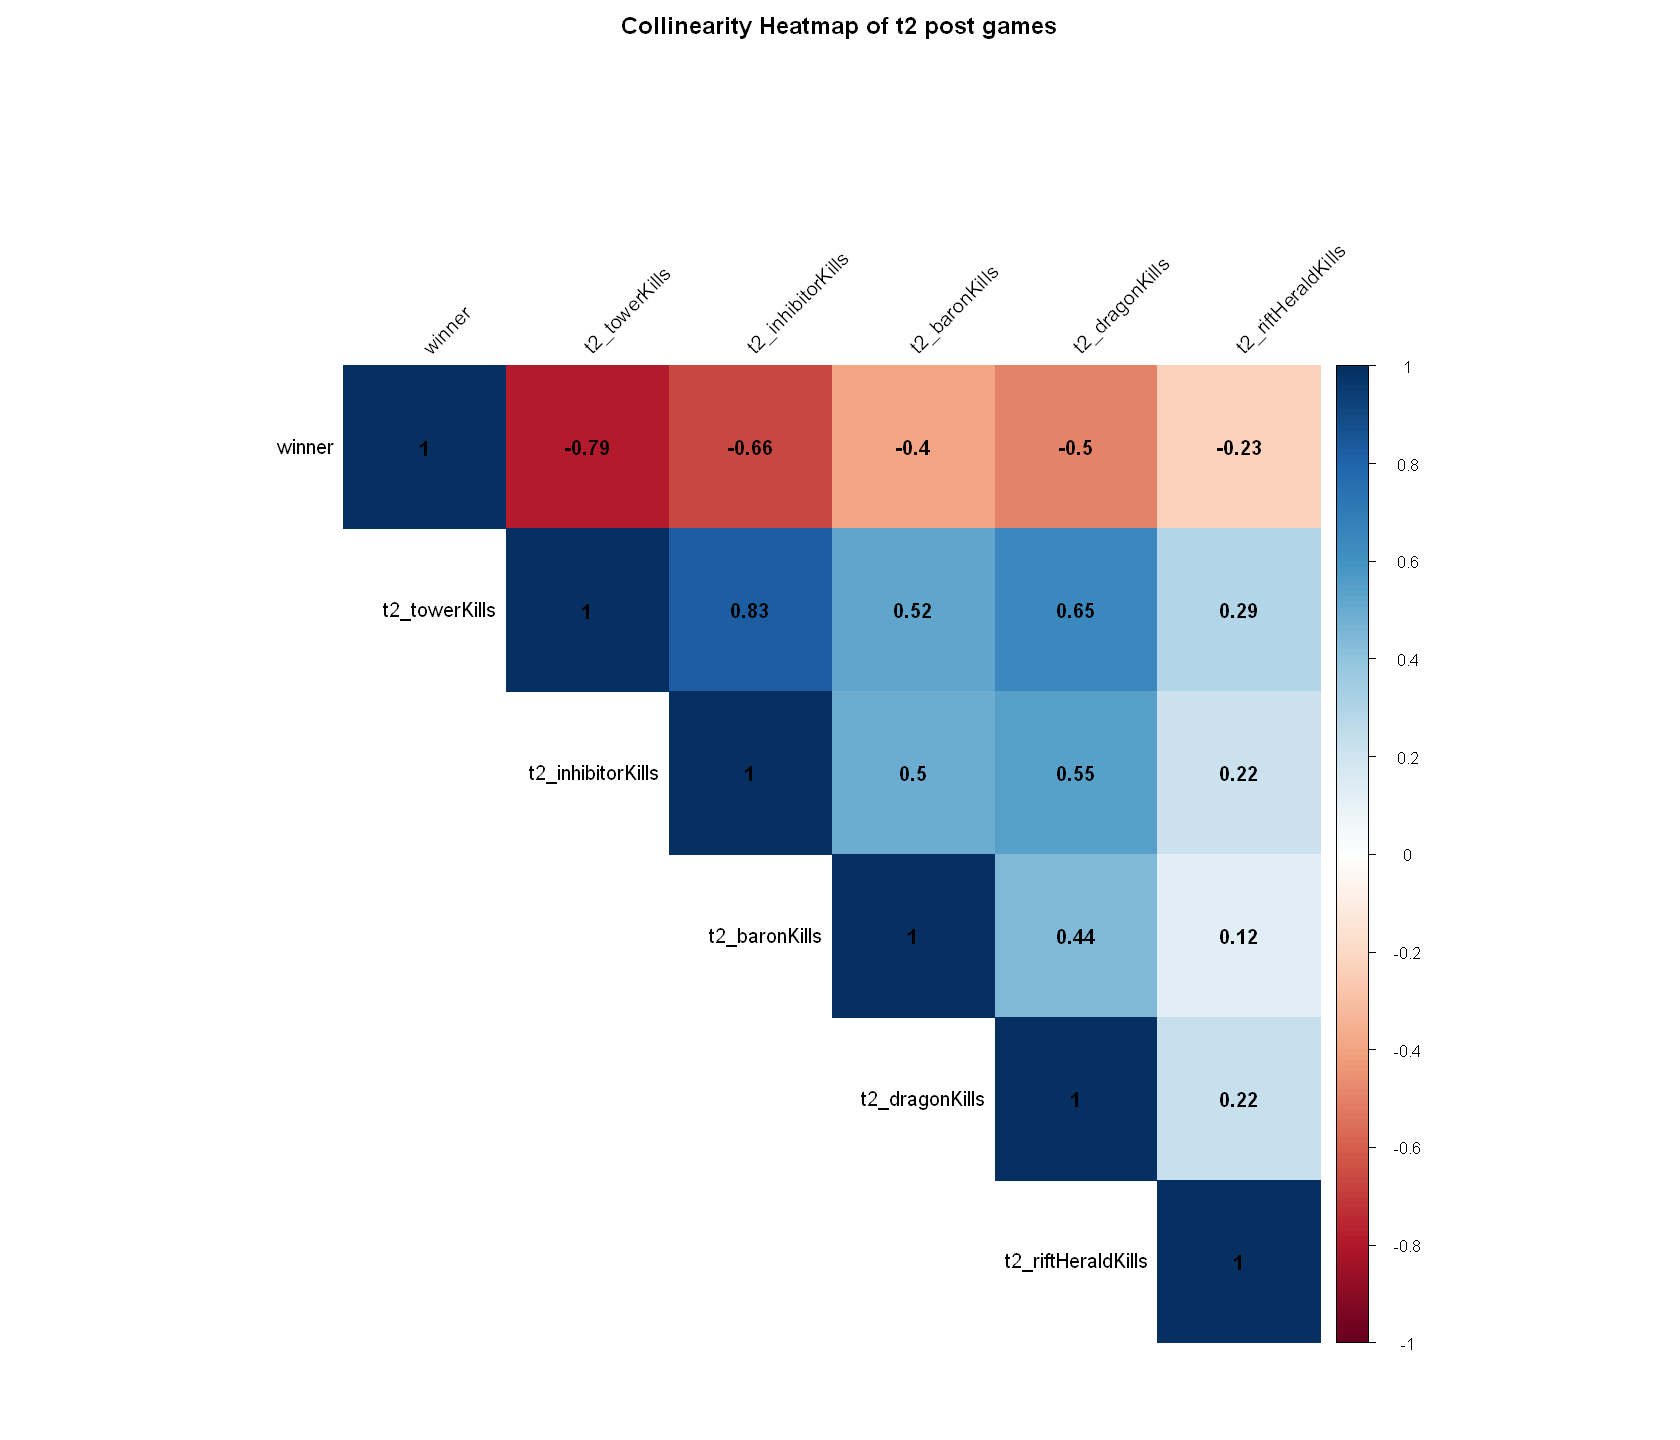

In [60]:
options(repr.plot.width = 14, repr.plot.height = 12) 

correlation_matrix_other <- data |>
  select(c( 5, 52, 53, 54, 55, 56)) |>
  cor()

par(mar = c(1, 1, 4, 1))  
corrplot(correlation_matrix_other, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, addCoef.col = "black",
         title = "Collinearity Heatmap of t2 post games", 
         mar = c(0, 0, 2, 0))

# Method


In [61]:
baseline_model <- glm(winner ~ ., data = df_post_start, family = binomial)

summary(baseline_model)




Call:
glm(formula = winner ~ ., family = binomial, data = df_post_start)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6762  -0.0399   0.0019   0.0338   3.5673  

Coefficients: (1 not defined because of singularities)
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.03839    0.06709   0.572  0.56719    
firstBlood         -0.11275    0.04585  -2.459  0.01392 *  
firstTower          0.68002    0.05590  12.165  < 2e-16 ***
firstInhibitor      0.55551    0.06423   8.649  < 2e-16 ***
firstBaron          0.00695    0.06704   0.104  0.91744    
firstDragon        -0.31686    0.06211  -5.102 3.37e-07 ***
firstRiftHerald     0.29828    0.03889   7.670 1.72e-14 ***
t1_towerKills       1.14803    0.02295  50.027  < 2e-16 ***
t1_inhibitorKills  -0.11630    0.04070  -2.858  0.00427 ** 
t1_baronKills       0.53480    0.05964   8.967  < 2e-16 ***
t1_dragonKills     -0.08684    0.03820  -2.273  0.02300 *  
t1_riftHeraldKills -0.65795    0.075

## data splitting

In [62]:
set.seed(1234)
df_selection <- initial_split(df_post_start, prob = 0.7, strata = winner)
df_train <- training(df_selection)
df_test <- testing(df_selection)

head(df_train)

winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,2,2,0,2,2,0,0,0,0,0,8,1,0,2,1
0,2,2,2,2,2,2,0,0,0,1,0,10,2,1,1,1
0,1,2,2,0,2,0,0,0,0,0,0,11,3,0,2,0
0,1,2,2,2,1,1,4,0,0,3,1,11,2,1,1,0
0,1,2,2,0,2,0,2,0,0,0,0,10,2,0,2,0
0,1,2,2,2,2,2,4,0,0,1,0,7,2,1,3,1


#### Using lasso

Splitting the training set into a design matrix and the y vector for cross validation 

In [63]:
set.seed(1234)
model_matrix_X_train <- model.matrix(~ . - 1, data = df_train[, -1])

matrix_Y_train <- 
    as.matrix(df_train$winner, ncol = 1)

In [64]:
set.seed(1234) # do not change this!

lol_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

lol_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure        SE Nonzero
min 0.000145    86  0.9951 0.0002393      14
1se 0.002593    55  0.9949 0.0002343       9

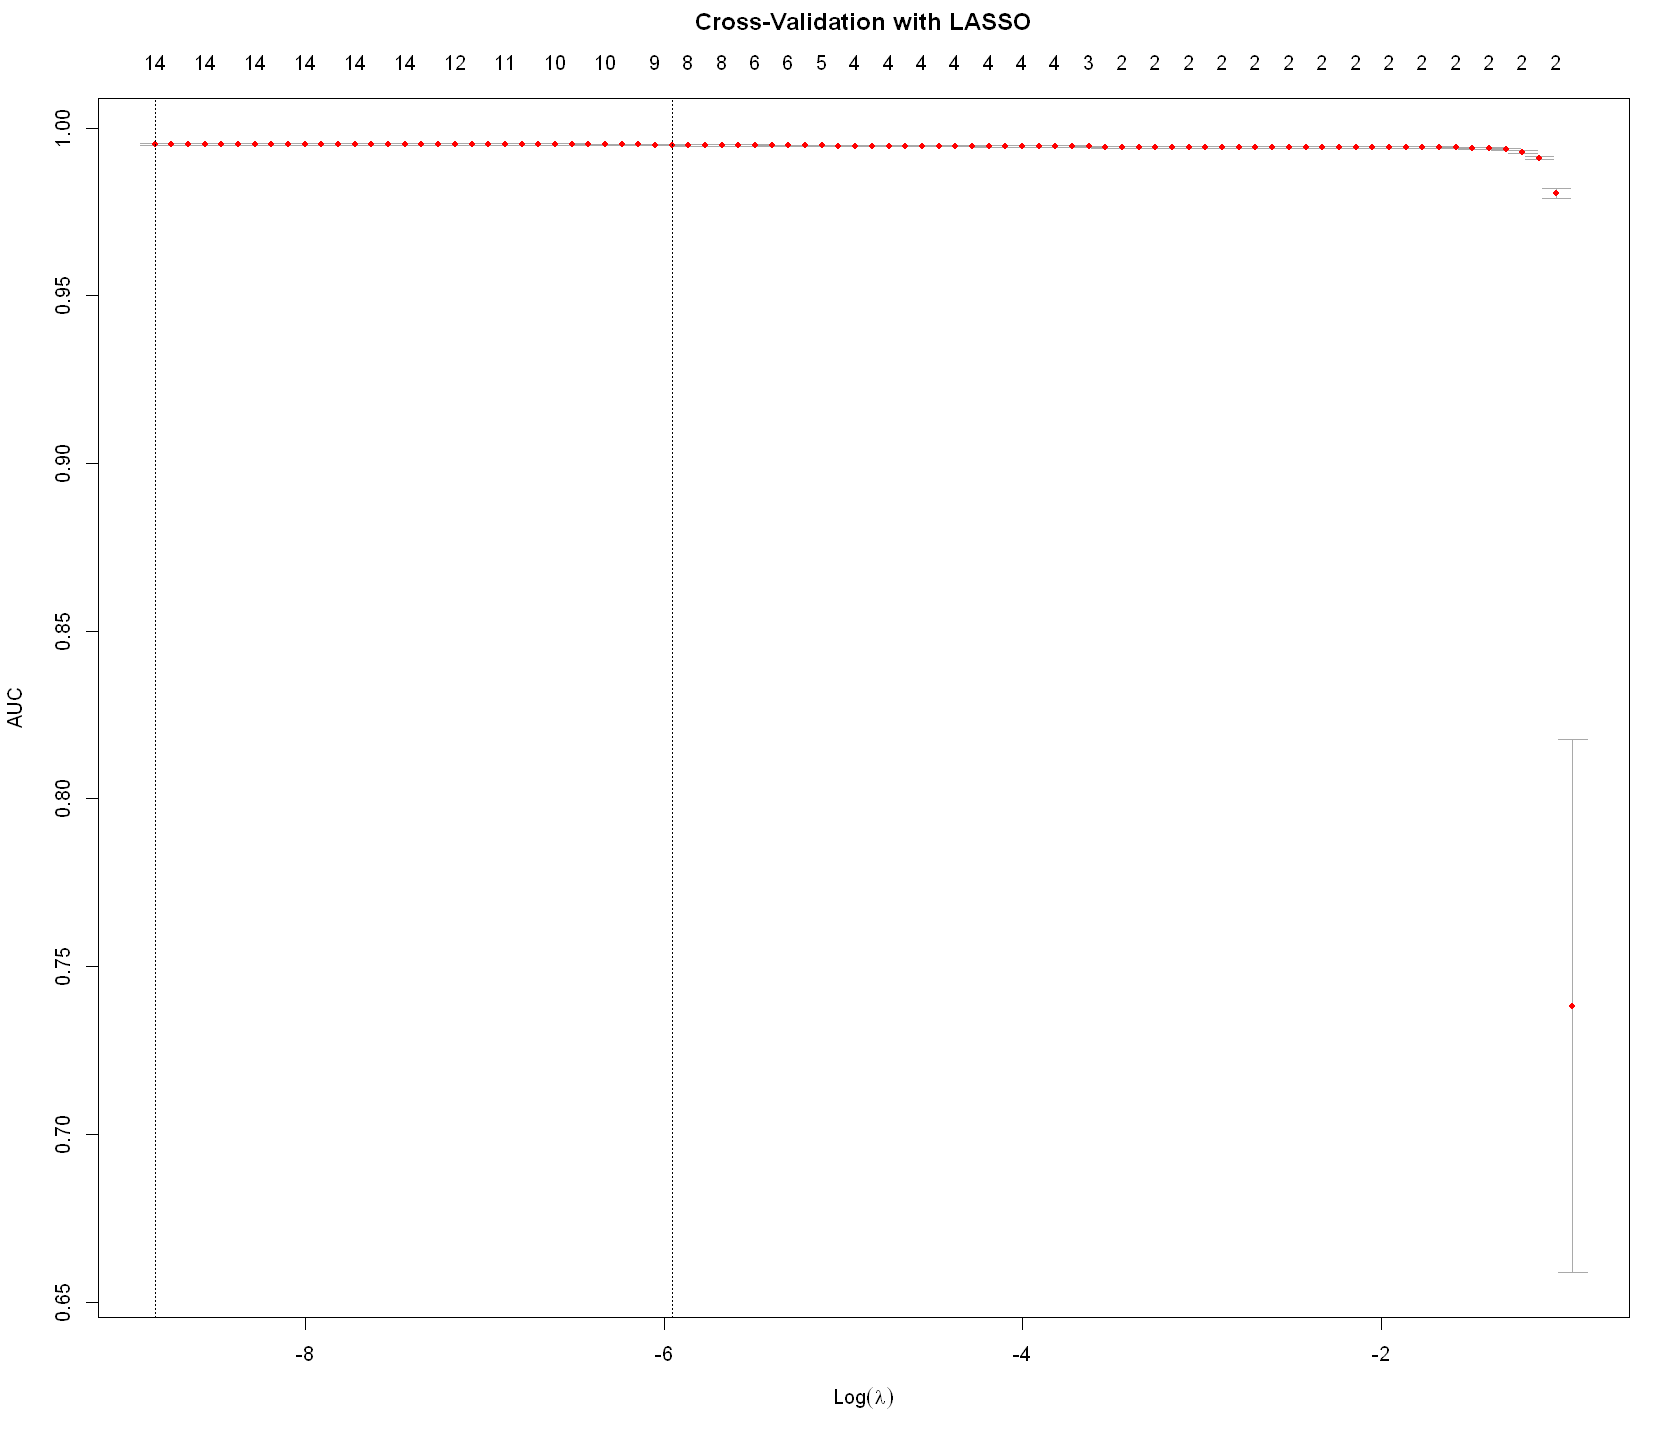

In [65]:
plot(lol_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

In [66]:
lol_lambda_min_AUC_LASSO <- round(lol_lambda_LASSO$lambda.min, 4)

lol_lambda_min_AUC_LASSO

[1] 1e-04

In [67]:
set.seed(1234) 

lol_LASSO_min_AUC <- glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  lambda = lol_lambda_min_AUC_LASSO
)


coef(lol_LASSO_min_AUC)

17 x 1 sparse Matrix of class "dgCMatrix"
                            s0
(Intercept)         0.05763505
firstBlood         -0.10076660
firstTower          0.66567041
firstInhibitor      0.55834254
firstBaron          .         
firstDragon        -0.28349114
firstRiftHerald     .         
t1_towerKills       1.10790400
t1_inhibitorKills  -0.11386982
t1_baronKills       0.56191053
t1_dragonKills     -0.04271016
t1_riftHeraldKills -0.34243109
t2_towerKills      -1.34210480
t2_inhibitorKills   0.20982243
t2_baronKills      -0.29686643
t2_dragonKills      0.04843969
t2_riftHeraldKills  0.50577869

In [68]:
best_auc_lasso <- lol_lambda_LASSO$cvm[which(lol_lambda_LASSO$lambda == lol_lambda_LASSO$lambda.min)]

best_auc_lasso

[1] 0.9951345

#### Using ridge

In [69]:
set.seed(1234) # do not change this!

lol_lambda_Ridge <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  type.measure = "auc",
  nfolds = 10)

lol_lambda_Ridge


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 0, family = "binomial") 

Measure: AUC 

     Lambda Index Measure        SE Nonzero
min 0.03941   100  0.9897 0.0002727      16
1se 0.04325    99  0.9895 0.0002751      16

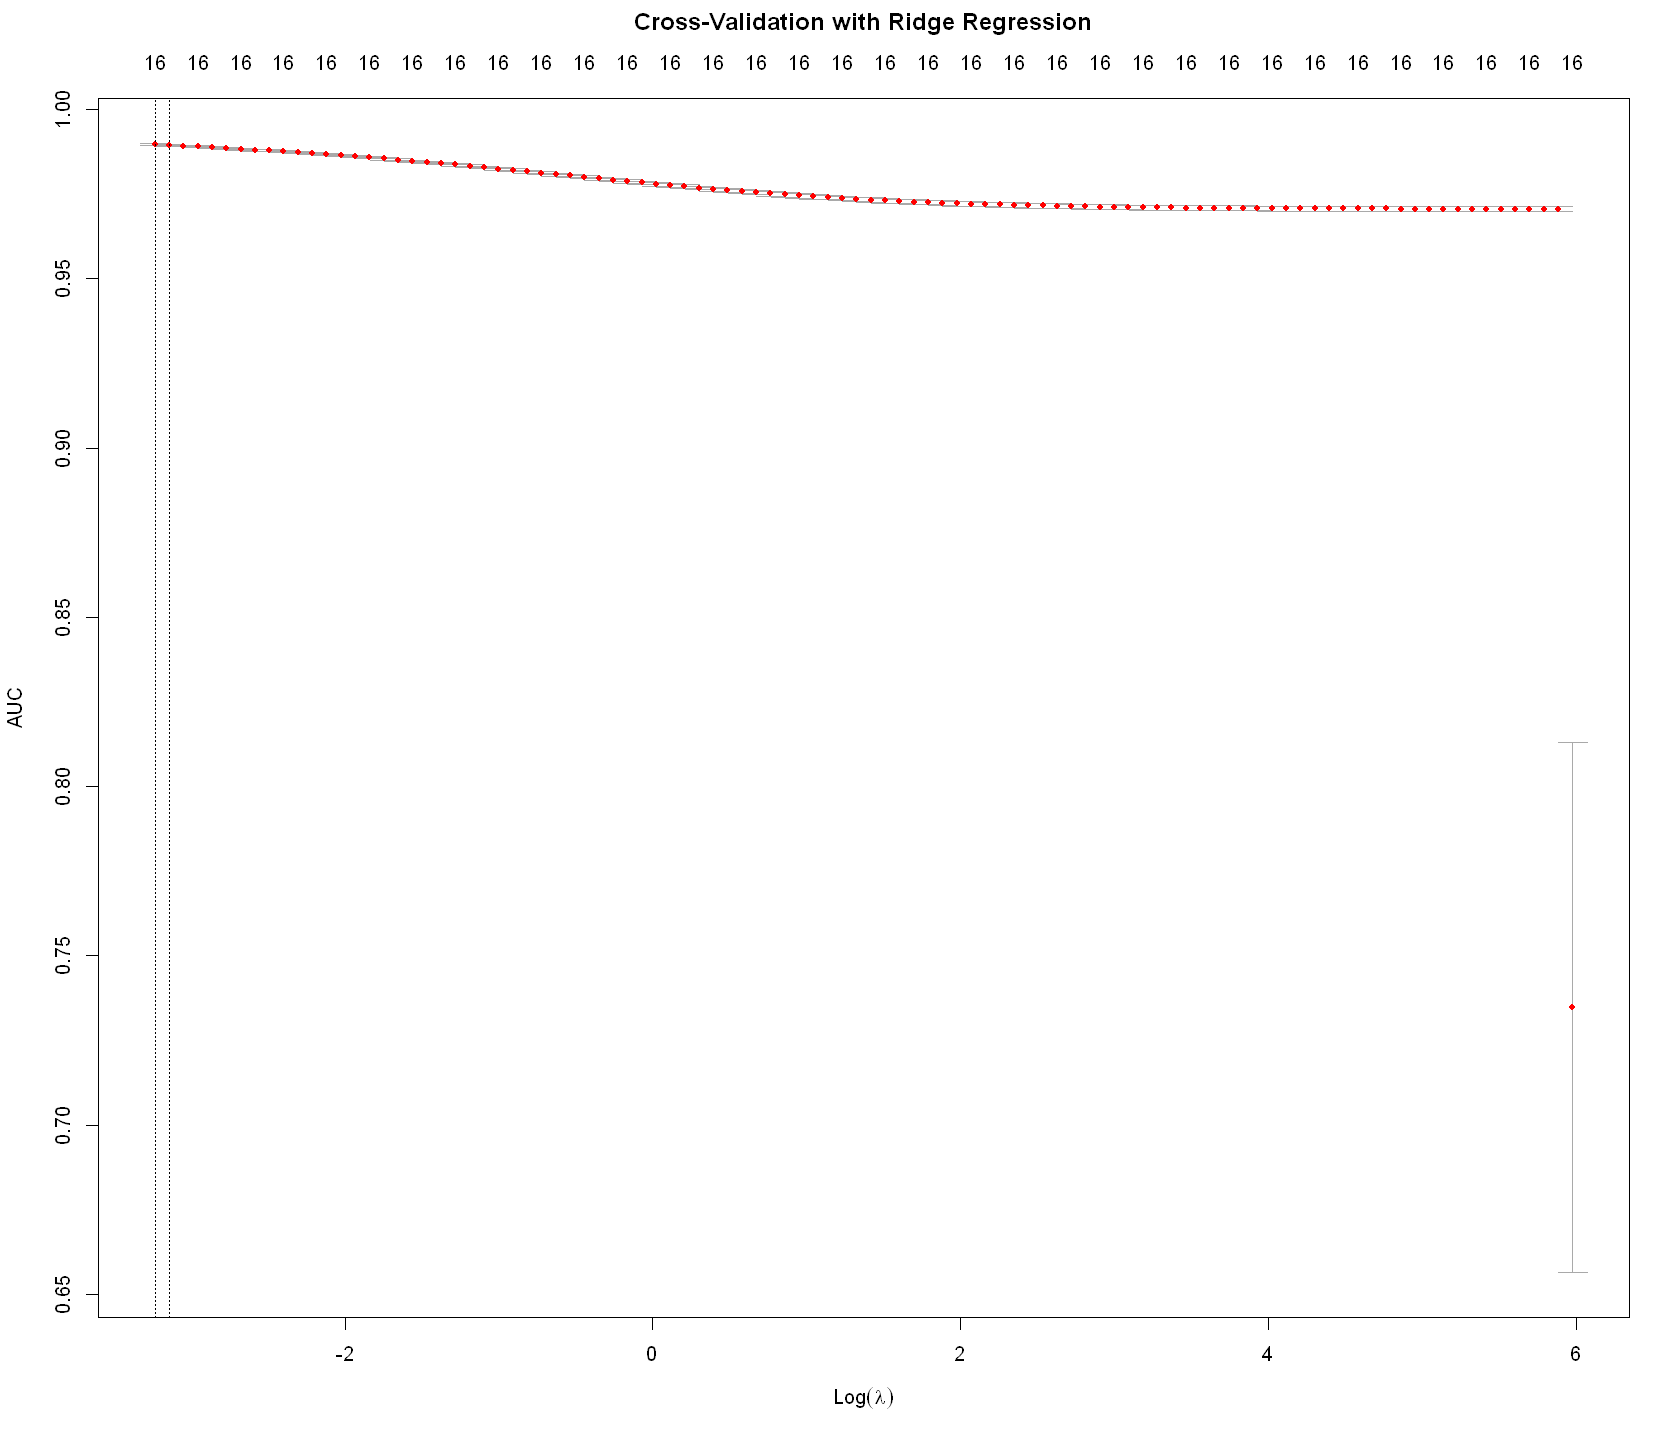

In [70]:
plot(lol_lambda_Ridge, 
     main = "Cross-Validation with Ridge Regression\n\n")

In [71]:
lol_lambda_max_AUC_ridge <- round(lol_lambda_Ridge$lambda.min, 4)

lol_lambda_max_AUC_ridge

[1] 0.0394

In [72]:
set.seed(1234) 

lol_ridge_max_AUC <- 
  glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 0,
  family = "binomial",
  lambda = lol_lambda_max_AUC_ridge
)


coef(lol_ridge_max_AUC)

17 x 1 sparse Matrix of class "dgCMatrix"
                            s0
(Intercept)         0.45740790
firstBlood         -0.12714799
firstTower         -0.12561951
firstInhibitor     -0.23770290
firstBaron         -0.07648706
firstDragon        -0.03276940
firstRiftHerald     0.00590585
t1_towerKills       0.27714644
t1_inhibitorKills   0.41203971
t1_baronKills       0.46283864
t1_dragonKills      0.17922355
t1_riftHeraldKills  0.08444423
t2_towerKills      -0.24683051
t2_inhibitorKills  -0.39230472
t2_baronKills      -0.38170090
t2_dragonKills     -0.13792907
t2_riftHeraldKills -0.03258958

In [73]:
best_auc_ridge <- lol_lambda_Ridge$cvm[which(lol_lambda_Ridge$lambda == lol_lambda_Ridge$lambda.min)]

best_auc_ridge

[1] 0.9896837

#### CV on baseline

In [74]:
set.seed(1234)
num.folds <- 10

folds <- createFolds(df_train$winner, k=num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(df_train), folds[[fold]])
regr.cv[[fold]] <- glm(winner ~ ., data=df_train, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=df_train$winner[test.idx],
pred=predict(regr.cv[[fold]], newdata=df_train, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

lol_cv_baseline <- round(mean(auc.cv),7)

cat("Cross-validation AUC for the ordinary logistic model:", 
lol_cv_baseline)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient

Cross-validation AUC for the ordinary logistic model: 0.9951462

#### forward selection

In [75]:
set.seed(1234)

# Perform forward selection using regsubsets
regfit_fwd <- regsubsets(winner ~ ., data = df_train, nvmax = NULL, method = "forward")

# Summary of the model
reg_summary <- summary(regfit_fwd)

# Get the model with the lowest BIC
best_model <- which.min(reg_summary$bic)
best_model

# Extract the selected predictors
selected_predictors <- names(coef(regfit_fwd, best_model))
selected_predictors <- selected_predictors[-1]  # Remove intercept
selected_predictors

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1  linear dependencies found"
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"nvmax reduced to  15"
Warning message in rval$lopt[] <- rval$vorder[rval$lopt]:
"number of items to replace is not a multiple of replacement length"


[1] 11

[1] "firstTower"         "firstInhibitor"     "firstBaron"        
 [4] "t1_towerKills"      "t1_baronKills"      "t1_dragonKills"    
 [7] "t1_riftHeraldKills" "t2_towerKills"      "t2_inhibitorKills" 
[10] "t2_baronKills"      "t2_riftHeraldKills"

In [79]:
set.seed(1234)
num.folds <- 10

folds <- createFolds(df_train$winner, k=num.folds)

regr.cv <- NULL
for (fold in 1:num.folds) {
train.idx <- setdiff(1:nrow(df_train), folds[[fold]])
regr.cv[[fold]] <- glm(winner ~ firstTower+ firstInhibitor+ firstBaron+ t1_towerKills+ t1_baronKills+t1_dragonKills+t1_riftHeraldKills+t2_towerKills+t2_baronKills+t2_inhibitorKills +t2_riftHeraldKills, data=df_train, subset=train.idx,
                       family="binomial")
    }

pred.cv <- NULL
auc.cv <- numeric(num.folds) 

for (fold in 1:num.folds) {
test.idx <- folds[[fold]]
pred.cv[[fold]] <- data.frame(obs=df_train$winner[test.idx],
pred=predict(regr.cv[[fold]], newdata=df_train, type="response")[test.idx])
auc.cv[fold] <- roc(obs ~ pred, data=pred.cv[[fold]])$auc
    }

lol_cv_forward <- round(mean(auc.cv),7)

cat("Cross-validation AUC for the forward selection logistic model:", 
lol_cv_forward)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Cross-validation AUC for the forward selection logistic model: 0.9950678

# Comparison

In [80]:
lol_AUC_models <- 
    tibble(
        model = c("baseline", "ridge", "lasso", "forward"),
        auc = c(lol_cv_baseline,best_auc_ridge, best_auc_lasso, lol_cv_forward))

lol_AUC_models

model,auc
<chr>,<dbl>
baseline,0.9951462
ridge,0.9896837
lasso,0.9951345
forward,0.9950678


# Evaluation

In [99]:
set.seed(1234)
model_matrix_X_test <- 
    model.matrix(~ . - 1, data = df_test[, -1])

ROC <- 
    roc(
        response = df_test$winner,
        predictor = predict(lol_LASSO_min_AUC,
                     newx = model_matrix_X_test)[,"s0"] ) 


ROC

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = df_test$winner, predictor = predict(lol_LASSO_min_AUC,     newx = model_matrix_X_test)[, "s0"])

Data: predict(lol_LASSO_min_AUC, newx = model_matrix_X_test)[, "s0"] in 6354 controls (df_test$winner 0) < 6520 cases (df_test$winner 1).
Area under the curve: 0.9949

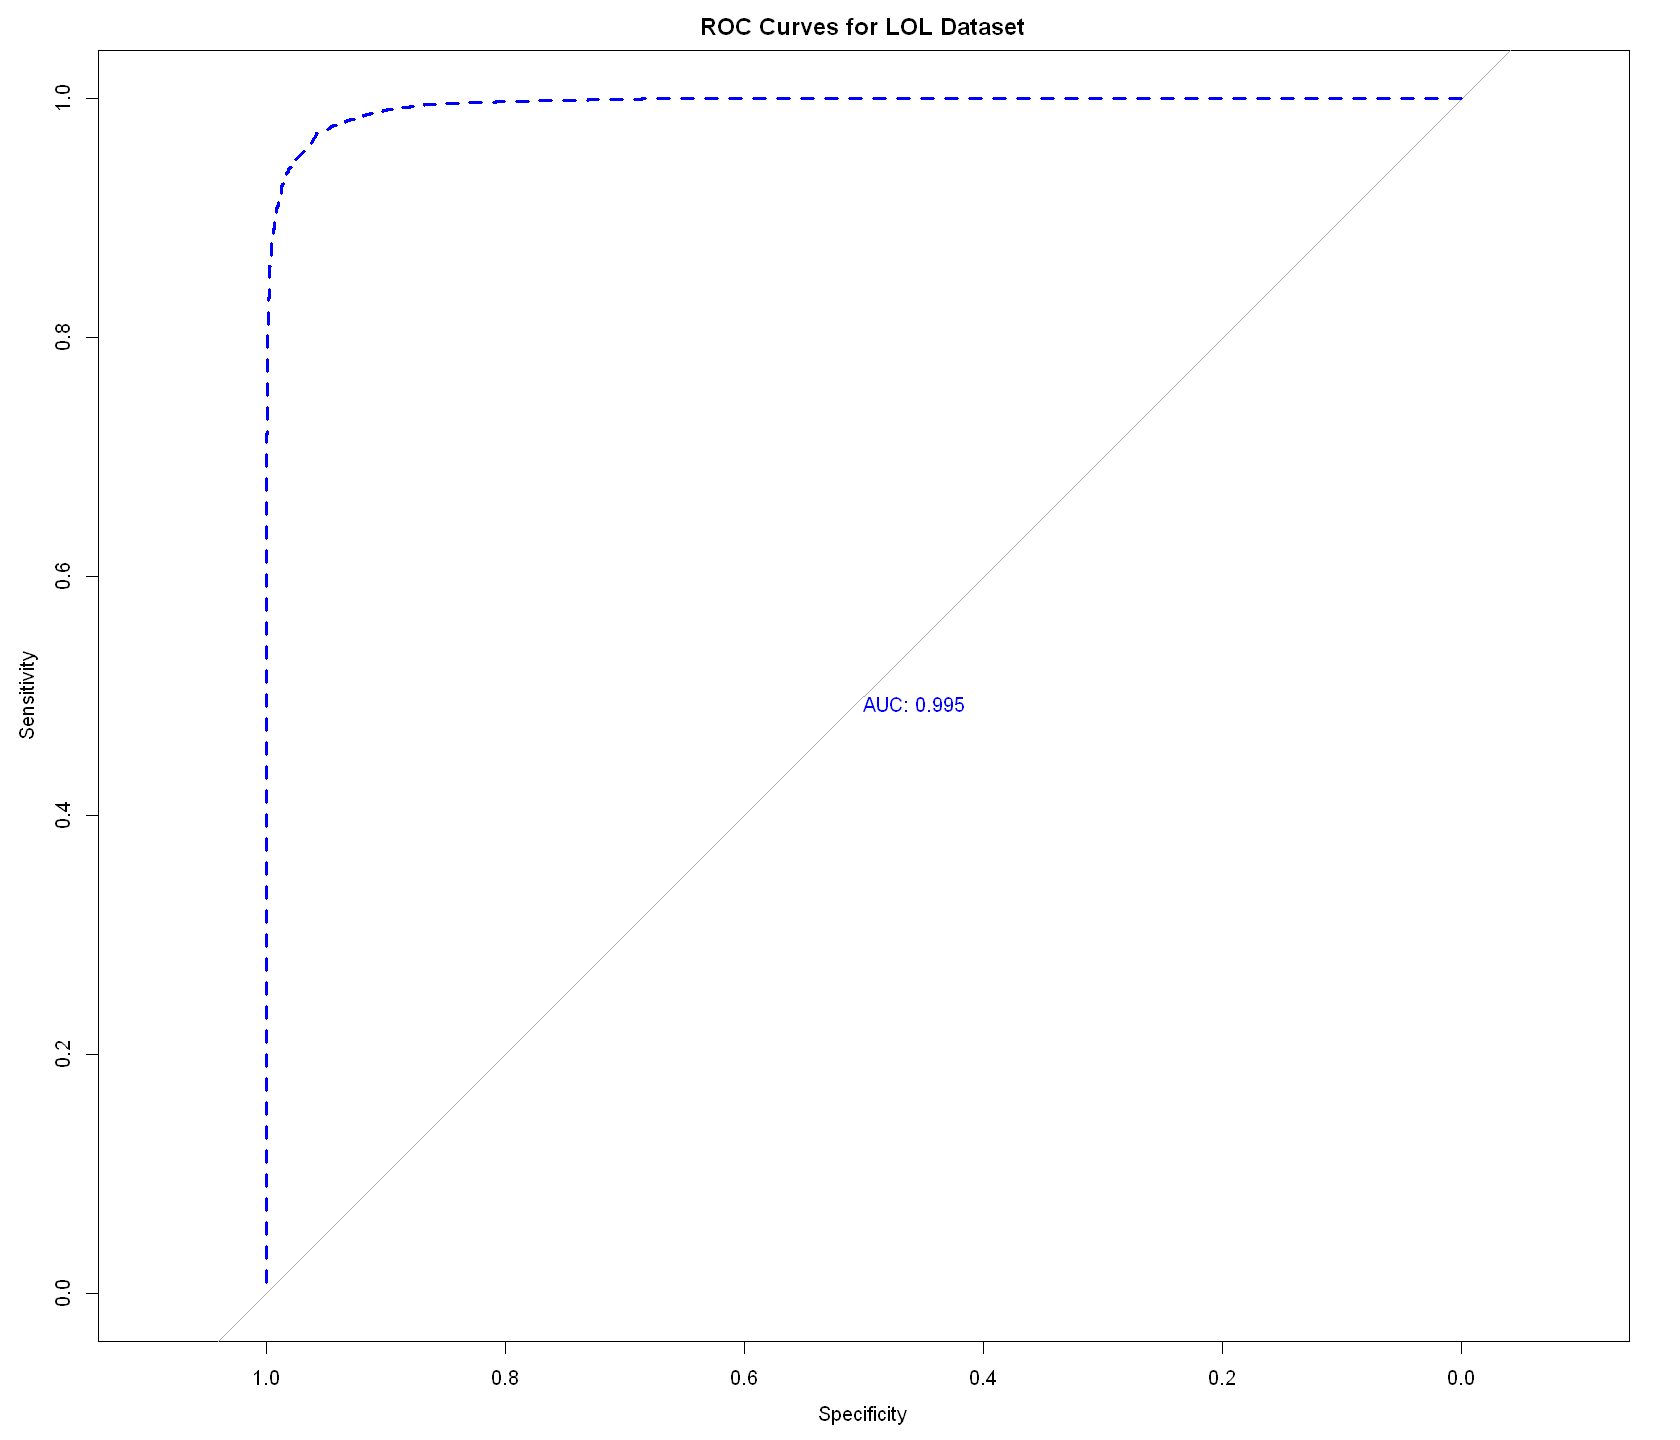

In [100]:
plot(ROC,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for LOL Dataset"
)

In [101]:
saveRDS(lol_LASSO_min_AUC, "lol_LASSO_min_AUC.rds")

In [103]:
install.packages("reticulate")

also installing the dependencies 'rprojroot', 'RcppTOML', 'here', 'png'





  There are binary versions available but the source versions are later:
           binary source needs_compilation
rprojroot   2.0.3  2.0.4             FALSE
reticulate   1.28 1.39.0              TRUE

  Binaries will be installed
package 'RcppTOML' successfully unpacked and MD5 sums checked
package 'here' successfully unpacked and MD5 sums checked
package 'png' successfully unpacked and MD5 sums checked
package 'reticulate' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\linh0\AppData\Local\Temp\Rtmp8O6oOI\downloaded_packages


installing the source package 'rprojroot'




In [107]:
library(reticulate)
use_python("G:/anaconda/envs/py10/python.exe", required = TRUE)
py_save_object(lol_LASSO_min_AUC, "lol_LASSO_min_AUC.pkl")

16 x 1 sparse Matrix of class "dgCMatrix"
                            s0
firstBlood         -0.10076660
firstTower          0.66567041
firstInhibitor      0.55834254
firstBaron          .         
firstDragon        -0.28349114
firstRiftHerald     .         
t1_towerKills       1.10790400
t1_inhibitorKills  -0.11386982
t1_baronKills       0.56191053
t1_dragonKills     -0.04271016
t1_riftHeraldKills -0.34243109
t2_towerKills      -1.34210480
t2_inhibitorKills   0.20982243
t2_baronKills      -0.29686643
t2_dragonKills      0.04843969
t2_riftHeraldKills  0.50577869


ERROR: Error in eval(expr, envir, enclos): Unable to convert R object to Python type
